# Метод сопряжённых градиентов (20 баллов)

In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools


seed = 57
rng = np.random.default_rng(seed)

## Основная часть (10 баллов)

Чтобы знакомство с библиотекой `torch` было не столь травмирующим, вернемся к библиотеке `numpy`. В ней вам будет предложено реализовать метод сопряженных градиентов для квадратичной задачи (см. домашнее задание про градиентный спуск).

__Задача 1.__ Напомним, что квадратичной задачей оптимизации называется

$$ \min_{x \in \mathbb{R}^d} \left[f(x) := \frac{1}{2} x^\top A x - b^\top x\right], $$

где $b \in \mathbb{R}^d$, $A \in \mathbb{S}_{++}^{d}$.

Как уже было вами показано, для данной задачи константы $L$-липшицевости и $\mu$-строгой выпуклости удовлетворяют следующим неравенствам:

$$L \geq \lambda_{\max}(A), \quad \mu \leq \lambda_{\min}(A).$$

Реализуйте функцию генерации квадратичной задачи (см. домашнее задание про градиентный спуск).

In [24]:
def generate_quadratic_problem(d, mu, L):
    """
    Генерирует квадратичную оптимизационную задачу:
    min_x f(x) = 0.5 * x^\top A x — b^\top x

    Параметры:
        d (int): Размерность задачи.
        mu (float): Константа сильной выпуклости (mu > 0).
        L (float): Константа гладкости (L > mu).

    Возвращает:
        A (np.array): Симметричная положительно определенная матрица размерности d x d.
        b (np.array): Вектор размерности d.
    """

    if mu <= 0 or L <= mu:
        raise ValueError("Условия mu > 0 и L > mu должны выполняться.")

    unitary_matrix, _ = np.linalg.qr(np.random.randn(d, d))
    diag_matrix = np.diag(np.linspace(mu + 1e-6, L - 1e-6, d))

    A = unitary_matrix @ diag_matrix @ unitary_matrix.T

    A = (A + A.T) / 2

    b = np.random.randn(d)

    return A, b

In [25]:
# Выполним проверку сгенерированной задачи при заданных параметрах
d = 5000
mu = 5.0
L = 200.0

A, b = generate_quadratic_problem(d, mu, L)

# Проверка, что A симметрична
assert np.allclose(A, A.T), "Матрица A не симметрична."

# Проверка собственных значений A
eigenvalues_A = np.linalg.eigvalsh(A)
assert np.min(eigenvalues_A) >= mu - 10e-6, "Минимальное собственное значение A меньше mu."
assert np.max(eigenvalues_A) <= L + 10e-6, "Максимальное собственное значение A больше L."

Напомним, что аналитическое решение данной задачи оптимизации имеет вид

$$ x^* = A^{-1}b.$$

A градиент в точке $x$ равен

$$\nabla f(x) = Ax - b.$$

Критерий сходимости будем использовать:

$$f(x) - f(x^*).$$

Найдите значение $x^*$ для сгенерированной квадратичной задачи, реализуйте функции подсчета значения функции потерь, градиента и критерий.

In [26]:
x_star = np.linalg.inv(A) @ b

In [27]:
def loss(x, A, b):
    """
    Вычисляет значение квадратичной функции f(x) = 0.5 * x^T A x - b^T x.

    Параметры:
        x (np.array): Точка, в которой вычисляется градиент
        A (np.array): Матрица квадратичной формы
        b (np.array): Вектор линейной части

    Возвращает:
        loss (np.array): Значение функции в точке x
    """

    return np.dot(A @ x, x) / 2 - np.dot(b, x)

In [28]:
def grad(x, A, b):
    """
    Вычисляет градиент квадратичной функции f(x) = 0.5 * x^T A x — b^T x.

    Параметры:
        x (np.array): Точка, в которой вычисляется градиент
        A (np.array): Матрица квадратичной задачи
        b (np.array): Вектор линейной части

    Возвращает:
        grad (np.array): Градиент функции в точке x
    """

    grad = A @ x - b

    return grad

In [29]:
def criterion(x, x_star, A, b, loss):
    """
    Вычисляет функциональный критерий сходимости: f(x) - f(x^*).

    Параметры:
        x (np.array): Текущая точка
        x_star (np.array): Точное решение

    Возвращает:
        criterion (float): Значение критерия
    """

    return loss(x, A, b) - loss(x_star, A, b)

__а) (3 балла)__ Реализуйте метод сопряженных градиентов.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальное приближение $x^0 \in \mathbb{R}^d$
- Начальная невязка $r_0 = \nabla f(x^0) $
- Начальное направление поиска $ p_0 = -r_0 $
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

1. Вычислить коэффициент $\alpha_k$:

   $$
   \alpha_k = alpha\_update\_rule(line\_search\_params)
   $$

2. Обновить $x^k$:

   $$
   x^{k+1} = x^k + \alpha_k \cdot p^k
   $$

3. Вычислить невязку:

   $$
   r^{k+1} = \nabla f(x^{k+1})
   $$

4. Вычислить коэффициент $\beta_k$:

   $$
   \beta_k = beta\_update\_rule(beta\_update\_rule\_params)
   $$

5. Обновить направление поиска:

   $$
   p^{k+1} = -r^{k+1} + \beta_k \cdot p^k
   $$

---

_Условие остановки:_

- Достигнуто максимальное число итераций $K$ или $f(x^k) - f(x^*) < \varepsilon$.

---

_Выход:_

- Полученное значение $x^K$.

In [30]:
def conjugate_gradient_descent(A, b, loss, grad, criterion, x_0, x_star, alpha_update_rule=None,
                               beta_update_rule=None, eps=1e-8, max_iter=1000, **params):
    """
    Метод сопряжённых градиентов.

    Параметры:
        A (np.array): Матрица квадратичной формы
        b (np.array): Вектор линейной части
        loss (Callable): Целевая функция
        grad (Callable): Функция для вычисления градиента
        criterion (Callable): Функция для вычисления критерия сходимости
        x_0 (np.array): Начальная точка
        x_star (np.array): Точное решение
        alpha_update_rule (Callable): Функция для вычисления коэффициента alpha_k.
        beta_update_rule (Callable): Функция для вычисления коэффициента beta_k.
        eps (float): Точность сходимости
        max_iter (int): Максимальное число итераций
        params (dict): Дополнительные параметры:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['alpha_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['alpha0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        errors (list): Список значений критерия сходимости на каждой итерации
    """

    values = []
    errors = []

    x_k = np.copy(x_0)
    errors.append(criterion(x_k, x_star, A, b, loss))

    grad_k = grad(x_k, A, b)
    p_k = -grad_k  # Начальное направление — антиградиент
    r_k = grad_k

    # Если alpha_update_rule не задан, используем постоянный шаг
    use_fixed_step = alpha_update_rule is None
    fixed_step = params.get('alpha_fixed', 1e-2)

    # Если beta_update_rule не задан, используем фиксированное значение
    use_fixed_beta = beta_update_rule is None
    fixed_beta = params.get('beta_fixed', 0.5)

    for k in tqdm(range(max_iter)):
        directional_derivative = grad_k.dot(p_k)
        if directional_derivative >= 0:
            p_k = -grad_k

        alpha = 0
        beta = 0

        if use_fixed_step:
          alpha = fixed_step
        else:
          alpha = alpha_update_rule(A, b, loss,
                                    grad, x_k, p_k,
                                    params.get('beta1', 0),
                                    params.get('beta2', 0),
                                    params.get('alpha_mult', 0),
                                    params.get('line_search_max_iter', 0),
                                    params.get('alpha0', 0))

        x_k = x_k + alpha * p_k

        r_k_prev = r_k
        r_k = grad(x_k, A, b)
        grad_k = r_k

        if use_fixed_beta:
          beta = fixed_beta
        else:
          beta = beta_update_rule(A=A, grad_prev=r_k_prev, grad_next=r_k, p=p_k)

        p_k = -r_k + beta * p_k

        errors.append(criterion(x_k, x_star, A, b, loss))

        if errors[-1] < eps:
            break

    return x_k, errors

Запустите метод с теоретическими $\alpha_k$:

$$
\alpha_k = -\frac{\langle r^k, p^k \rangle}{\langle p^k, Ap^k \rangle}
$$

и теоретическим $\beta_k$:

$$
\beta_k = \frac{\langle r^{k + 1}, A p^k \rangle}{\langle p^k, Ap^k \rangle}
$$

В качестве начальной точки возьмите нулевой вектор той же размерности, что и решение.

In [31]:
def alpha_theoretical(A, b, loss, grad, x, p, beta1=0, beta2=0, alpha_mult=0, max_iters=0, alpha0=0):
    """
    Подсчет теоретического alpha.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Нужен для совместимости
        beta2 (float): Нужен для совместимости
        alpha_mult (float): Нужен для совместимости
        max_iters (int): Нужен для совместимости
        alpha0 (float): Нужен для совместимости

    Возвращает:
        alpha (float): Найденное значение alpha
    """
    r_k = grad(x, A, b)

    numerator = np.dot(r_k, p)
    denominator = np.dot(p, A @ p)

    return -numerator / denominator

In [32]:
def beta_theoretical(A, grad_prev, grad_next, p):
    """
    Подсчет теоретического beta.

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """
    numerator = np.dot(grad_next, p)
    denominator = np.dot(p, A @ p)

    return numerator / denominator

In [33]:
x_0 = np.zeros(d)

x_star_cg, errors_cg = conjugate_gradient_descent(
    A=A,
    b=b,
    loss=loss,
    grad=grad,
    criterion=criterion,
    x_0=x_0,
    x_star=x_star,
    alpha_update_rule=alpha_theoretical,
    beta_update_rule=beta_theoretical,
    eps=1e-8,
    max_iter=1000
)

 18%|█▊        | 179/1000 [00:21<01:37,  8.38it/s]


Постройте график сходимости.

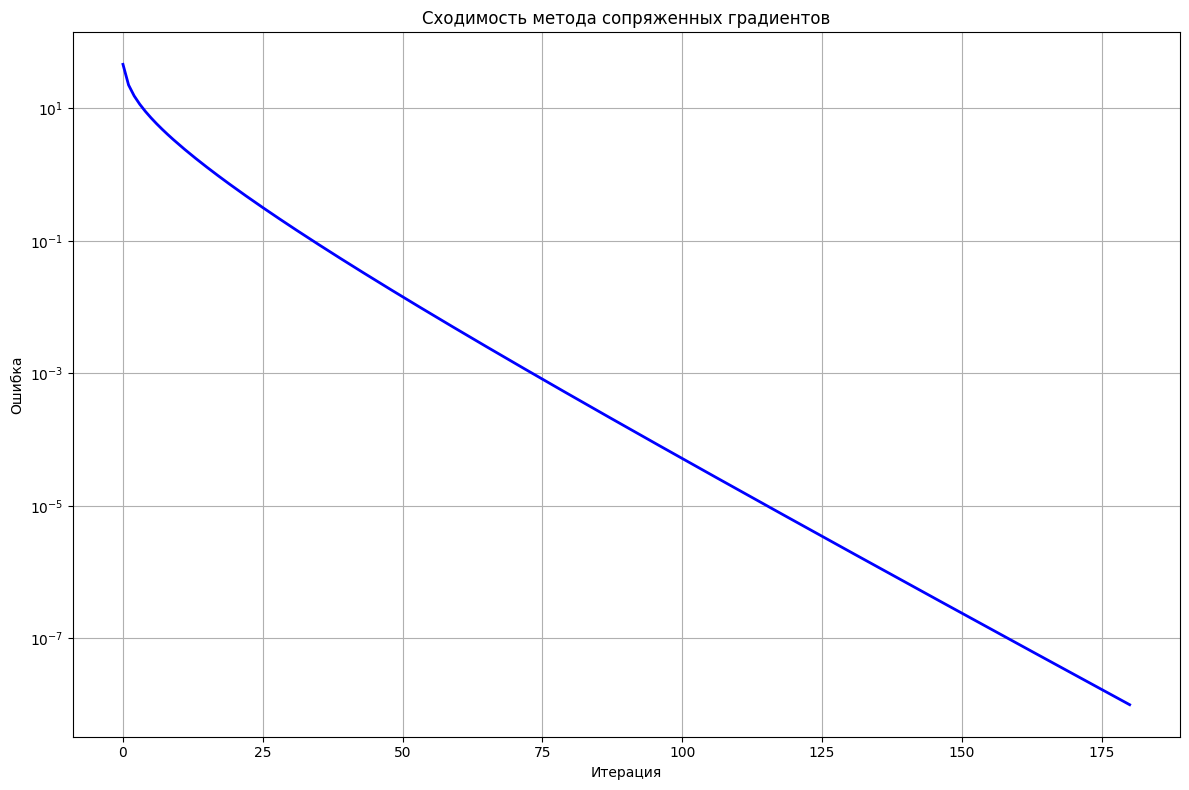

In [34]:
plt.figure(figsize=(12, 8))
plt.semilogy(range(len(errors_cg)), errors_cg, linewidth=2, color='blue')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Сходимость метода сопряженных градиентов')
plt.grid(True)
plt.tight_layout()
plt.show()

__б) (1 балл)__  Запустите метод c постоянными $\alpha_k$ и $\beta_k$. Используйте следующие параметры `alpha_fixed` = $10^{-2}$, `beta_fixed` = $0.5$.

In [35]:
x_cg_fixed, errors_cg_fixed = conjugate_gradient_descent(
    A=A,
    b=b,
    loss=loss,
    grad=grad,
    criterion=criterion,
    x_0=x_0,
    x_star=x_star,
    alpha_update_rule=None,
    beta_update_rule=None,
    eps=1e-8,
    max_iter=1000,
    alpha_fixed=1e-2,
    beta_fixed=0.5
)

  7%|▋         | 74/1000 [00:04<00:52, 17.72it/s]


Постройте график сходимости с постоянным шагом и с теоретическим шагом.

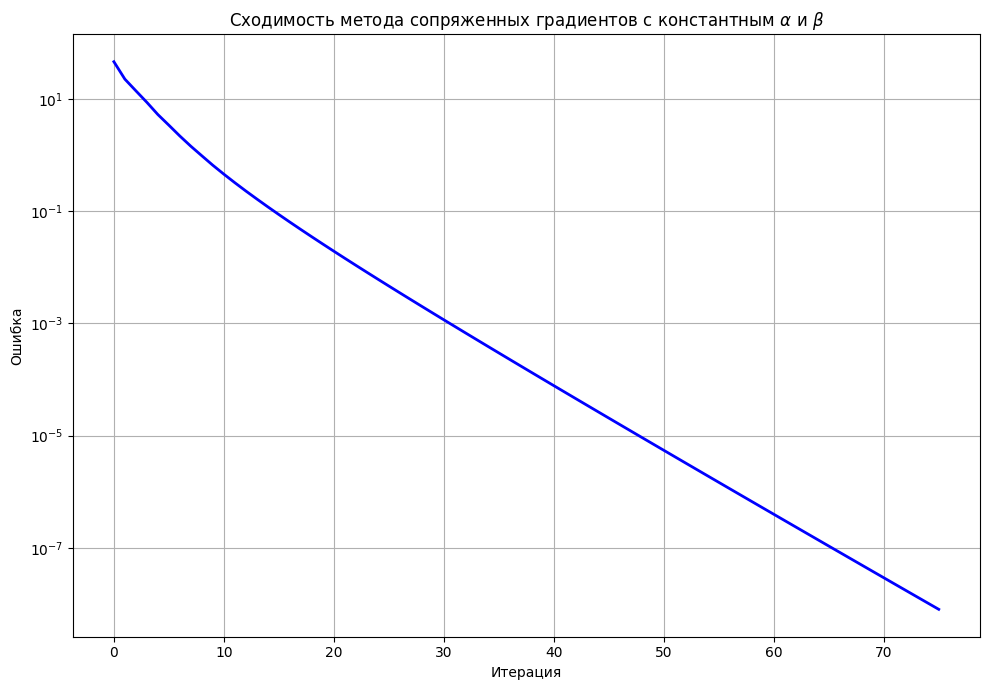

In [36]:
plt.figure(figsize=(10, 7))
plt.semilogy(range(len(errors_cg_fixed)), errors_cg_fixed, linewidth=2, color='blue')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title(r'Сходимость метода сопряженных градиентов с константным $\alpha$ и $\beta$')
plt.grid(True)
plt.tight_layout()
plt.show()

__в) (3 балла)__ Добавим теперь функции линейного поиска шага. Допишите (см. дополнительную часть задания про ускоренные и оптимальные методы) функцию `armijo` и `strong_wolfe`.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\alpha_0 > 0$
- Направление спуска $p^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметр $\beta_1 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \alpha_k p^k\right) \leq f\left(x^k\right) + \beta_1 \alpha_k \langle \nabla f(x^k), p^k \rangle
$$

2. Если условие выполнено — вернуть $\alpha_k$. Иначе — уменьшить шаг:

    $$
    \alpha_k = m \cdot \alpha_k
    $$

    и вернуться к 1.

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\alpha_k$

In [37]:
def armijo(A, b, loss, grad, x, p, beta1, beta2, alpha_mult, max_iters, alpha0):
    """
    Правило Армихо.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Не используется, оставлен для совместимости
        alpha_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        alpha0 (float): Начальное значение шага

    Возвращает:
        alpha (float): Найденное значение шага, удовлетворяющее условию Армихо
    """
    alpha = alpha0
    counter = 0
    current_loss = loss(x, A, b)
    grad_x = grad(x, A, b)
    directional_derivative = grad_x.dot(p)
    if directional_derivative >= 0:
      p = -grad_x


    while counter < max_iters:

        x_new = x + alpha * p
        new_loss = loss(x_new, A, b)

        if new_loss <= current_loss + beta1 * alpha * directional_derivative:
            return alpha

        alpha *= alpha_mult
        counter += 1

    return alpha

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\alpha_0 > 0$
- Направление спуска $p^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \alpha_k p^k\right) \leq f\left(x^k\right) + \beta_1 \alpha_k \langle \nabla f\left(x^k\right), p^k \rangle
$$

2. Проверить сильное условие кривизны

$$
|\langle \nabla f \left(x^k + \alpha_k p^k\right),  p^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), p^k \rangle|
$$

2. Если оба условия выполняются, вернуть $\alpha_k$. Если не выполняется Армихо или направление положительное — уменьшить шаг:

    $$\alpha_k = \alpha_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\alpha_k = \alpha_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\alpha_k$

In [38]:
def strong_wolfe(A, b, loss, grad, x, p, beta1, beta2, alpha_mult, max_iters, alpha0):
    """
    Сильное правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Параметр кривизны
        alpha_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        alpha0 (float): Начальное значение шага

    Возвращает:
        alpha (float): Найденное значение шага, удовлетворяющее условию сильного Вольфа
    """
    alpha = alpha0
    counter = 0
    current_loss = loss(x, A, b)
    grad_x = grad(x, A, b)
    directional_derivative = grad_x.dot(p)

    while counter < max_iters:

        x_new = x + alpha * p
        new_loss = loss(x_new, A, b)
        grad_new = grad(x_new, A, b)
        new_directional_derivative = grad_new.dot(p)

        armijo_condition = new_loss <= current_loss + beta1 * alpha * directional_derivative

        curvature_condition = abs(new_directional_derivative) <= beta2 * abs(directional_derivative)

        if armijo_condition and curvature_condition:
            return alpha

        if not armijo_condition or new_directional_derivative >= 0:
            alpha *= alpha_mult
        else:
            alpha /= alpha_mult

        counter += 1

    return alpha

Запустите метод с линейным поиском Армихо и сильным Вольфом. Используйте параметры $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$, `alpha_mult=0.5`, `line_search_max_iter=100`, $\alpha_0 = 0.5$ при фиксированном $\beta$.

In [39]:
params_linear_search = {
    'beta1': 1e-4,
    'beta2': 0.9,
    'alpha_mult': 0.5,
    'line_search_max_iter': 100,
    'alpha0': 0.5,
    'beta_fixed': 0.5
}

In [40]:
x_cg_armijo, errors_cg_armijo = conjugate_gradient_descent(
    A=A,
    b=b,
    loss=loss,
    grad=grad,
    criterion=criterion,
    x_0=x_0,
    x_star=x_star,
    alpha_update_rule=armijo,
    beta_update_rule=None,
    eps=1e-8,
    max_iter=1000,
    **params_linear_search
)

  6%|▌         | 61/1000 [00:14<03:36,  4.33it/s]


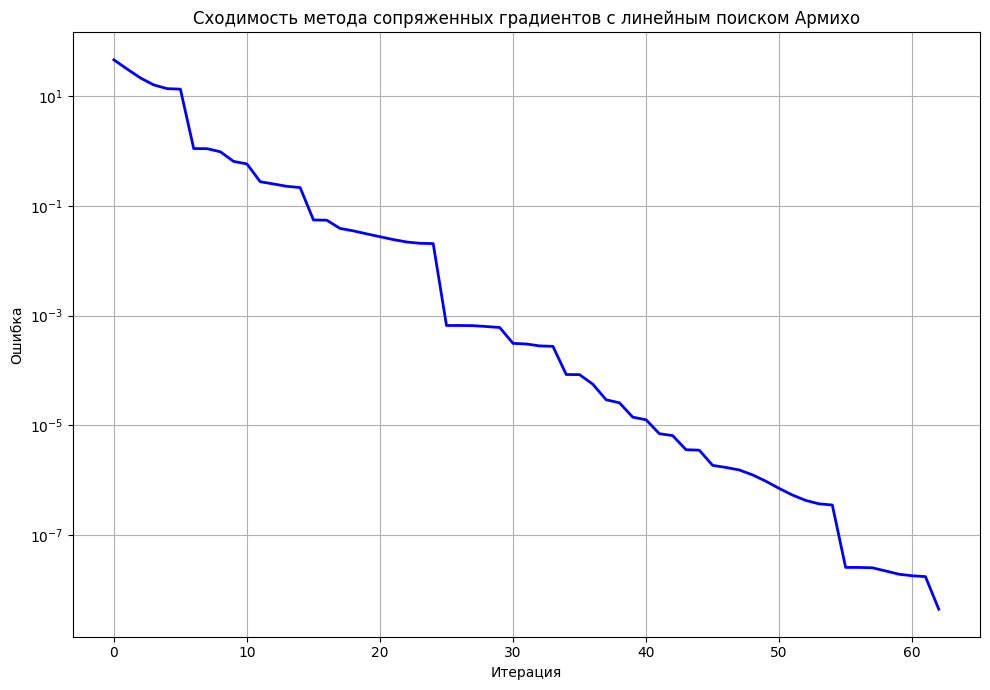

In [41]:
plt.figure(figsize=(10, 7))
plt.semilogy(range(len(errors_cg_armijo)), errors_cg_armijo, linewidth=2, color='blue')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Сходимость метода сопряженных градиентов c линейным поиском Армихо')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
x_cg_wolfe, errors_cg_wolfe = conjugate_gradient_descent(
    A=A,
    b=b,
    loss=loss,
    grad=grad,
    criterion=criterion,
    x_0=x_0,
    x_star=x_star,
    alpha_update_rule=strong_wolfe,
    beta_update_rule=None,
    eps=1e-8,
    max_iter=1000,
    **params_linear_search
)

  6%|▌         | 62/1000 [00:22<05:39,  2.76it/s]


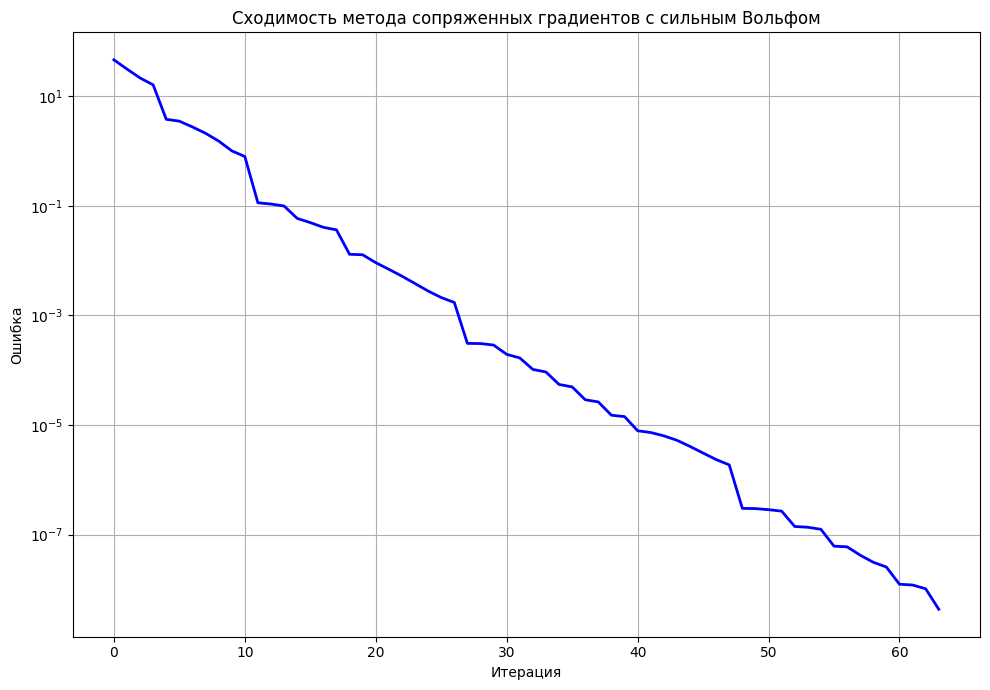

In [43]:
plt.figure(figsize=(10, 7))
plt.semilogy(range(len(errors_cg_wolfe)), errors_cg_wolfe, linewidth=2, color='blue')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Сходимость метода сопряженных градиентов с сильным Вольфом')
plt.grid(True)
plt.tight_layout()
plt.show()

Сравните данные методы с результатами из предыдущих пунктов.

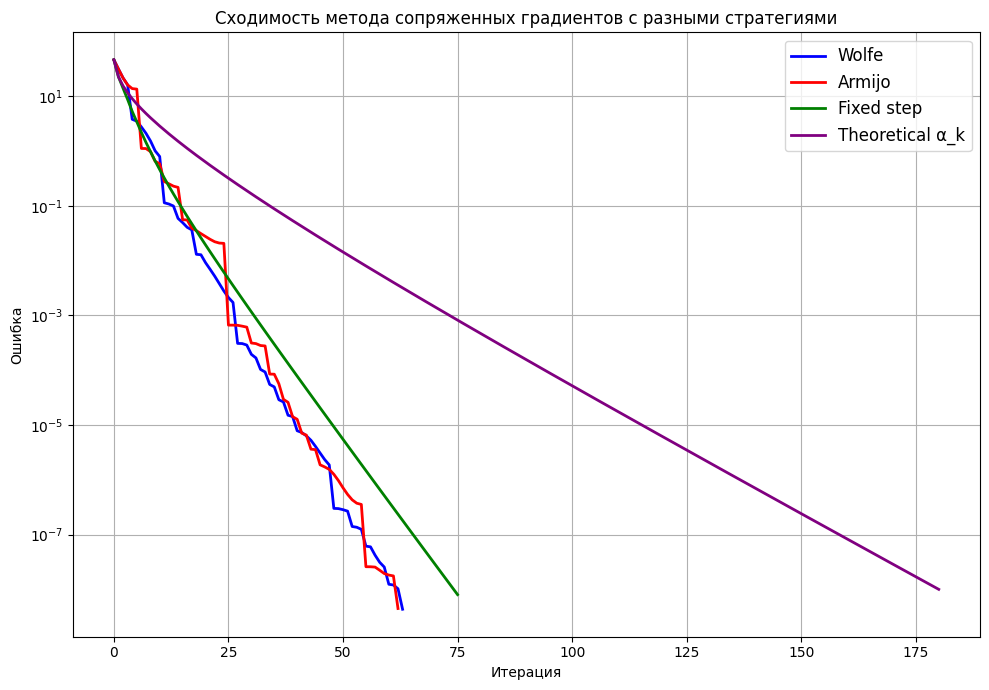

In [44]:
plt.figure(figsize=(10, 7))
plt.semilogy(range(len(errors_cg_wolfe)), errors_cg_wolfe, linewidth=2, color='blue', label='Wolfe')
plt.semilogy(range(len(errors_cg_armijo)), errors_cg_armijo, linewidth=2, color='red', label='Armijo')
plt.semilogy(range(len(errors_cg_fixed)), errors_cg_fixed, linewidth=2, color='green', label='Fixed step')
plt.semilogy(range(len(errors_cg)), errors_cg, linewidth=2, color='purple', label='Theoretical α_k')

plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Сходимость метода сопряженных градиентов с разными стратегиями')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


__г) (3 балла)__ Теперь перейдем к ключевому элементу — реализации поиска параметра $\beta$ по различным правилам. Рассмотрим три из них:

1. Флетчера-Ривса (FR):

$$
    \beta_{\text{FR}} = \frac{\| r^{k + 1} \|_2^2}{\| r^k \|_2^2}
$$

2. Полака-Рибьера (PRP):

$$
    \beta_{\text{PRP}} = \frac{\langle r^{k + 1}, r^{k + 1} - r^k \rangle}{\| r^k \|_2^2}
$$

3. Хестенса–Штифеля (HF):

$$
    \beta_{\text{HF}} = \frac{\langle r^{k + 1}, r^{k + 1} - r^k \rangle}{\langle p^k, r^{k + 1} - r^k \rangle}
$$

Дополнить код для каждого правила обновления $\beta$.

In [45]:
def beta_fr(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Флетчера-Ривса).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """

    return np.dot(grad_next, grad_next) / np.dot(grad_prev, grad_prev)

def beta_prp(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Полака-Рибьера).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """

    numerator = np.dot(grad_next, grad_next - grad_prev)
    denominator = np.dot(grad_prev, grad_prev)

    return numerator / denominator

def beta_hf(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Хестенса–Штифеля).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """

    numerator = np.dot(grad_next, grad_next - grad_prev)
    denominator = np.dot(p, grad_next - grad_prev)

    return numerator / denominator

Проведите анализ работы метода в зависимости от наличия/отсутствия конкретных правил обновления параметров $\alpha$ и $\beta$. Выявите, какой метод предлагает лучшую сходимость.

In [46]:
results = []

x_theoretical, errors_theoretical = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=alpha_theoretical,
    beta_update_rule=beta_theoretical,
    eps=1e-8, max_iter=1000
)
results.append(("Теоретический alpha + теоретический beta", errors_theoretical))

x_fr, errors_fr = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=alpha_theoretical,
    beta_update_rule=beta_fr,
    eps=1e-8, max_iter=1000
)
results.append(("Теоретический alpha + FR", errors_fr))

x_prp, errors_prp = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=alpha_theoretical,
    beta_update_rule=beta_prp,
    eps=1e-8, max_iter=1000
)
results.append(("Теоретический alpha + PRP", errors_prp))

x_hf, errors_hf = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=alpha_theoretical,
    beta_update_rule=beta_hf,
    eps=1e-8, max_iter=1000
)
results.append(("Теоретический alpha + HF", errors_hf))

x_armijo_fr, errors_armijo_fr = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=armijo,
    beta_update_rule=beta_fr,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Армихо + FR", errors_armijo_fr))

x_armijo_prp, errors_armijo_prp = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=armijo,
    beta_update_rule=beta_prp,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Армихо + PRP", errors_armijo_prp))

x_armijo_hf, errors_armijo_hf = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=armijo,
    beta_update_rule=beta_hf,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Армихо + HF", errors_armijo_hf))

x_wolfe_fr, errors_wolfe_fr = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=strong_wolfe,
    beta_update_rule=beta_fr,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Сильный Вольф + FR", errors_wolfe_fr))

x_wolfe_prp, errors_wolfe_prp = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=strong_wolfe,
    beta_update_rule=beta_prp,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Сильный Вольф + PRP", errors_wolfe_prp))

x_wolfe_hf, errors_wolfe_hf = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=strong_wolfe,
    beta_update_rule=beta_hf,
    eps=1e-8, max_iter=1000,
    **params_linear_search
)
results.append(("Сильный Вольф + HF", errors_wolfe_hf))

x_fixed, errors_fixed = conjugate_gradient_descent(
    A=A, b=b, loss=loss, grad=grad, criterion=criterion,
    x_0=x_0, x_star=x_star,
    alpha_update_rule=None,
    beta_update_rule=None,
    eps=1e-8, max_iter=1000,
    alpha_fixed=1e-2,
    beta_fixed=0.5
)
results.append(("Постоянные коэффициенты", errors_fixed))

  7%|▋         | 74/1000 [00:04<00:50, 18.25it/s]


Постройте графики для лучших методов.

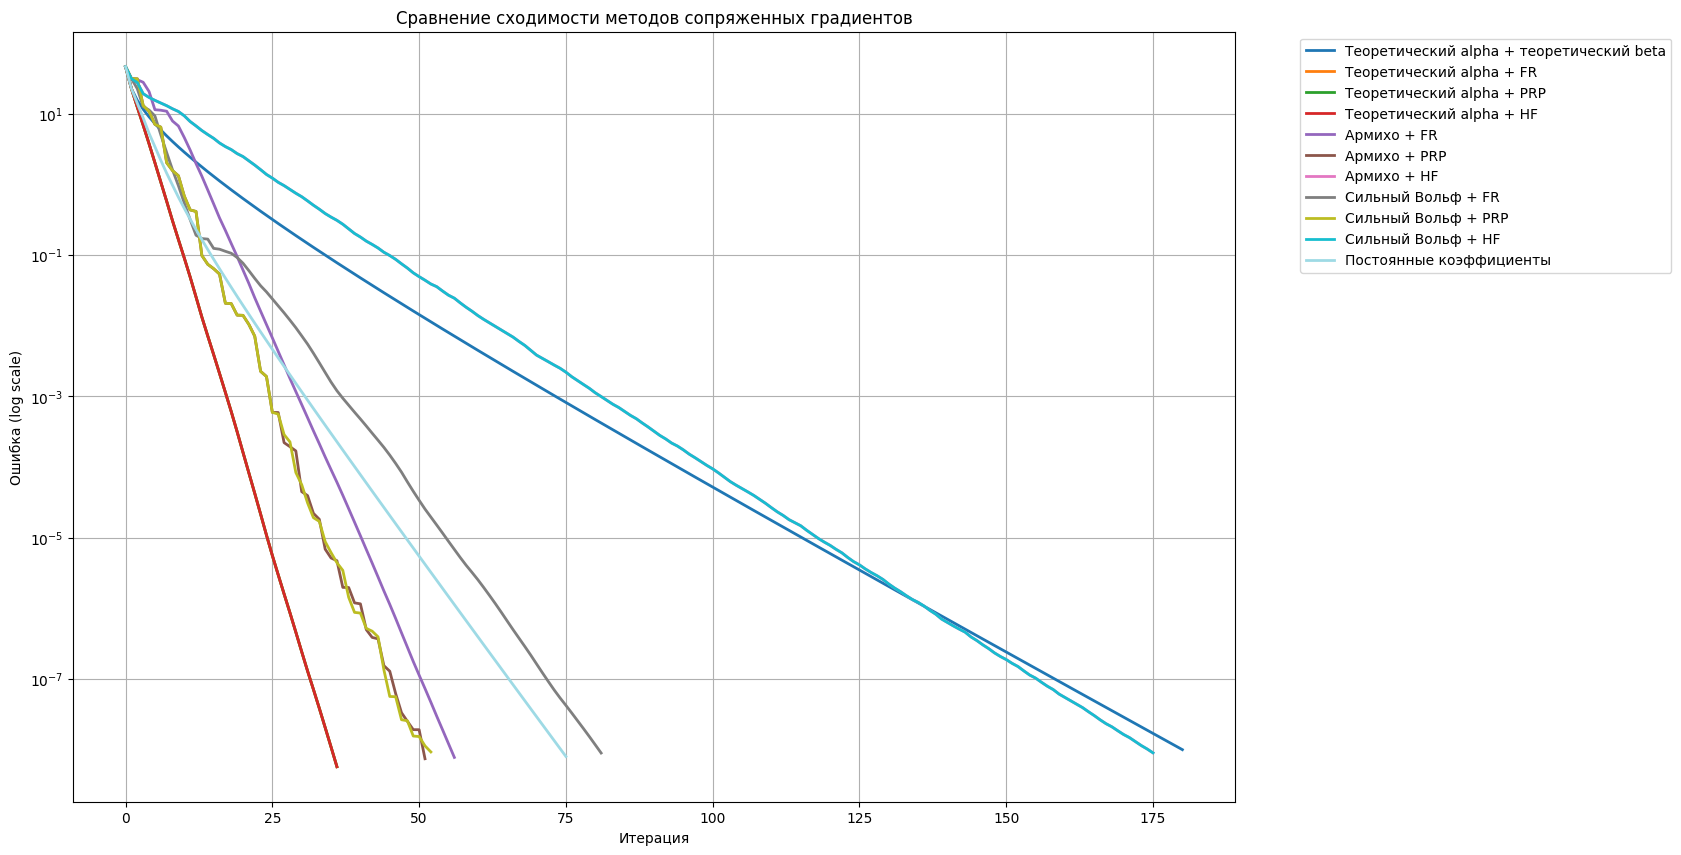

In [47]:
plt.figure(figsize=(15, 10))

colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

for i, (name, errors) in enumerate(results):
    plt.semilogy(range(len(errors)), errors, linewidth=2, color=colors[i], label=name)
plt.xlabel('Итерация')
plt.ylabel('Ошибка (log scale)')
plt.title('Сравнение сходимости методов сопряженных градиентов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)



## Дополнительная часть (10 баллов)

In [48]:
from scipy.sparse import csr_matrix, diags, eye
from scipy.sparse.linalg import eigs
import networkx as nx
import requests
import gzip

__Задача 2.__ В данной части мы рассмотрим алгоритм __PageRank__, представленный в 1998 году основателями Google. Для чего он нужен:
- Качественное ранжирование веб-страниц в условиях экспоненциального роста интернета
- Объективная оценка "авторитетности" страниц вне зависимости от содержимого
- Борьба с поисковым спамом и манипуляциями

__Симуляция поиска в интернете__

PageRank моделирует поведение гипотетического пользователя (_Random Surfer_), который:
- С вероятностью $\alpha$ (обычно 0.85) переходит по случайной ссылке на текущей странице
- С вероятностью $1-\alpha$ "телепортируется" на случайную страницу

__Random Surfer Model__

Пусть:

- $n$ — количество веб-страниц
- $P$ — матрица переходов размерности $n \times n$, где $P_{ij} = \begin{cases} \frac{1}{d_i} & \text{если страница } i \text{ ссылается на } j \\ 0 & \text{иначе} \end{cases}$
- $d_i$ — количество исходящих ссылок со страницы $i$

В простейшей модели стохастического графа блужданий верен результат __эргодической теоремы для марковских процессов__, а именно:

Если пустить блуждать человека по графу в течение длительного времени так, что человек будет случайно перемещаться со страницы на страницу согласно весам ребер графа, то доли $\{x_k\}_{k = 1}^n$ времени, которые человек провел на разных страницах, будут удовлетворять следующему уравнению:

$$
\sum_{i = 1}^n x_i P_{ij} = x_j \iff x^{\top} P = x^{\top} \iff x = P^{\top} x,
$$

имеющему единственное решение, удовлетворяющее $\sum \limits_{i = 1}^n x_i = 1$.

__Некоторые проблемы простоты модели случайного блуждания__

- _Проблема 1_: Тупиковые узлы

    Определение: Страницы без исходящих ссылок ($d_i = 0$)

    Проблема: Матрица $P$ становится нестохастической

    Решение: Замена нулевых столбцов на $\frac{1}{n} \mathbf{1}$:
    
    $$
    \tilde{P} = P + \frac{1}{n} \mathbf{1} \mathbf{d}^{\top},
    $$
    
    где $\mathbf{d}$ — индикатор тупиковых узлов

- _Проблема 2_: Несвязность графа

    Определение: Наличие изолированных компонент в графе

    Проблема: Отсутствие эргодичности, неединственность стационарного распределения

    Решение: Добавление телепортации:
    
    $$
    G = \alpha \tilde{P} + (1-\alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top}
    $$

Учитывая все вышеописанные проблемы, решение задачи PageRank принимает следующий вид:

$$
x = G^{\top} x \iff x = \left( \alpha \tilde{P} + (1 - \alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top} \right)^{\top} x \iff x = \left( \alpha \left(P + \frac{1}{n} \mathbf{1} \mathbf{d}^{\top}\right) + (1 - \alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top} \right)^{\top} x.
$$

Раскроем скобки и получим вид задачи в изначальных обозначениях:

$$
x = \alpha \left(P + \frac{1}{n} \mathbf{1} \mathbf{d}^{\top} \right)^{\top} x + (1 - \alpha) \frac{1}{n} \mathbf{1}.
$$

__а) (1 балл)__ Проверьте, что $G^{\top}$ является сжимающим отображением по бесконечной норме.

Возьмем $\phi(x) = G^T x$, покажем, что $\phi(x)$ - сжимающее отображение по определению.

Распишем просто $\phi(x) - \phi(y)$:
$$
\phi(x) - \phi(y) = G^Tx - G^Ty = G^T(x-y) = \alpha \tilde{P}^T(x-y) + (1-\alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top}(x-y)
$$

Но $\mathbf{1}^{\top}(x-y) = 0$.

Тогда
$$
\phi(x) - \phi(y) = \alpha \tilde{P}^T(x-y)
$$

Рассмотрим $\Vert \tilde{P}^Ta\Vert_{\infty}$, хотим показать, что $\Vert \tilde{P}^Ta\Vert_{\infty} \leq \Vert a\Vert_{∞}$.

Рассмотрим $j$-ю компоненту вектора: $|\tilde{P}^Ta |_j = |\sum_{i=1}^n\tilde{P}^T_{ij}a_i | = \sum_{i=1}^n\tilde{P}^T_{ij} |a_i | \leq \Vert a \Vert_{∞} \cdot \sum_{i=1}^n\tilde{P}^T_{ij} =$[Матрица Стохастическая]$=\Vert a \Vert_{∞}$
И это выполнено $\forall j$, следовательно
$$
\Vert \tilde{P}^Ta\Vert_{\infty} \leq \Vert a\Vert_{∞}
$$

Подставим $a = x-y$:
$$
\Vert \phi(x) - \phi(y) \Vert_{∞} = \Vert \alpha \tilde{P}^T(x-y) \Vert_{∞} \leq \alpha \Vert x - y\Vert_{∞}
$$

Следовательно, отображение сжимающее по определению



__б) (1 балл)__ Допишите метод простой итерации для нахождения вектора решения $x$. Напомним, что методом простой итерации называют поиск решения для сжимающих отображений $G$ по следующему правилу:

$$
x^{k + 1} = G^{\top} x^k.
$$

_Замечание: после каждой итерации необходима нормировка._

In [49]:
def power_iteration(tilde_P, alpha, max_iter=1000, eps=1e-8):
    """
    Метод простой итерации для решения задачи PageRank

    Параметры:
        tilde_P (csr_matrix): Модифицированная матрица переходов
        alpha (float): Коэффициент затухания
        max_iter (int): Максимальное число итераций
        eps (float): Точность остановки

    Возвращает:
        x (np.array): Вектор PageRank
        residuals (list): История норм невязки
    """
    n = tilde_P.shape[0]
    v = np.ones(n) / n  # Вектор телепортации
    x = np.ones(n) / n  # Начальное приближение
    errors = []

    for i in tqdm(range(max_iter)):

        x_new = alpha * tilde_P.T.dot(x) + (1 - alpha) * v

        x_new /= np.sum(x_new)

        # Вычисление невязки
        errors.append(1e6 * np.linalg.norm(x_new - x))

        # Проверка сходимости
        if errors[-1] < eps:
            break

        x = np.copy(x_new)

    return x, errors

__в) (1 балл)__ Сведите задачу PageRank к квадратичной задаче минимизации.

_Замечание: Для уменьшения размера выражения, выразите все через $\tilde{P}$._

$x = \alpha \tilde{P}^{\top} x + (1 - \alpha) \frac{1}{n} \mathbf{1}.$

Возьмем $A = \mathbf{1} - \alpha \tilde{P}^{\top}, b = (1 - \alpha) \frac{1}{n} \mathbf{1}$.

Тогда это переписывается как $Ax=b$.

Тогда это минимизация $\phi(x) = \frac{1}{2} \Vert Ax-b\Vert_2^2$

__в) (2 балла)__ Так как мы теперь умеем сводить задачу к квадратичной, то можно воспользоваться методом сопряженных градиентов, гарантирующий квадратичную сходимость. Допишите метод `conjugate_gradient_pagerank`. Используйте теоретическое значение $\alpha_k$ и $\beta_k = \beta_{FR}$.

_Замечание: используйте функцию `eye` из `scipy.sparse`._

In [50]:
def conjugate_gradient_pagerank(tilde_P, alpha, max_iter=1000, eps=1e-8):
    """
    Решение задачи PageRank методом сопряжённых градиентов

    Параметры:
        tilde_P (csr_matrix): Модифицированная матрица переходов
        alpha (float): Коэффициент затухания
        eps (float): Точность остановки
        max_iter (int): Максимальное число итераций

    Возвращает:
        x_k (np.array): Найденное решение
        errors (list): История невязок
    """
    n = tilde_P.shape[0]
    x_0 = np.ones(n) / n # Начальное приближение
    v = np.ones(n) / n  # Вектор телепортации

    A = eye(n, format='csr') - alpha * tilde_P.T

    b = (1 - alpha) * v

    # Градиент функции потерь
    def grad(x, A=A, b=b):
        return A.T @ (A @ x - b)

    # Критерий остановки
    def criterion(x_new, x_old):
        return np.linalg.norm(x_new - x_old)

    # Инициализация
    errors = []

    x_k = np.copy(x_0)
    grad_prev = grad(x_k)
    p_k = -grad_prev

    for k in tqdm(range(max_iter)):

        alpha_k = alpha_theoretical(A, b, loss, grad, x_k, p_k)

        x_new = x_k + alpha_k * p_k
        grad_new = grad(x_new)

        beta_k = beta_fr(A, grad_prev, grad_new, p_k)

        p_k = -grad_new + beta_k * p_k
        errors.append(1e6 * np.linalg.norm(x_new - x_k))


        if errors[-1] < eps:
            break

        x_k = np.copy(x_new)
        grad_prev = grad_new

    x_k /= np.sum(x_k)

    return x_k, errors

__г) (1 балл)__ Теперь сгенерируем саму задачу. Для этого вам нужно дополнить метод `build_transition_matrix`, который должен возвращать стохастическую версию матрицы $P$ (то есть $\tilde{P}$).

_Замечание: используйте функцию `diags` из `scipy.sparse`._

In [51]:
def build_transition_matrix(links, n):
    """
    Строит стохастическую матрицу переходов с учётом тупиковых страниц.

    Параметры:
        links (list): Список пар (from, to)
        n (int): Количество страниц

    Возвращает:
        tilde_P (csr_matrix): Модифицированная матрица переходов
    """
    if not links:
        return diags(np.ones(n), format='csr')


    links = np.array(links, dtype=int)
    src = links[:, 0]
    dst = links[:, 1]

    out_deg = np.bincount(src, minlength=n)

    weights = 1.0 / np.maximum(out_deg[src], 1)

    P = csr_matrix((weights, (dst, src)), shape=(n, n))

    d = (out_deg == 0).astype(float)

    tilde_P = P + np.outer(np.ones(n) / n, d)

    return csr_matrix(tilde_P)

In [52]:
def generate_web_graph(n, density=0.1):
    """
    Генерирует случайный граф.
    """
    num_links = int(n * n * density)
    sources = np.random.randint(0, n, num_links)
    targets = np.random.randint(0, n, num_links)
    return list(zip(sources, targets))

In [53]:
def visualize_web_graph(links, n, pr_vector=None):
    """
    Визуализирует граф с цветами по значению PageRank.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    G.add_edges_from(links)

    if pr_vector is None:
        pr_vector = np.ones(n) / n

    # Позиции вершин
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(
        G, pos, node_color=pr_vector,
        cmap=plt.cm.viridis, node_size=300, alpha=0.8
    )
    nx.draw_networkx_edges(
        G, pos, edge_color='gray',
        arrowstyle='->', arrowsize=10,
        connectionstyle='arc3,rad=0.1'
    )

    top_pages = np.argsort(pr_vector)[::-1][:5]
    for i, page in enumerate(top_pages):
        x, y = pos[page]
        plt.text(x, y+0.05, f"{page}: {pr_vector[page]:.4f}",
                fontsize=10, ha='center',
                bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f'Веб-граф: {n} страниц, {len(links)} связей')

    ax = plt.gca()

    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=ax, label='PageRank')
    plt.axis('off')
    plt.show()

__д) (2 балл)__ Запустите метод простой итерации и метод сопряженных градиентов.

In [54]:
# Параметры задачи
n = 1000  # Количество страниц
density = 0.001  # Плотность связей
alpha = 0.85  # Коэффициент затухания
max_iter = 300  # Максимальное число итераций
eps = 1e-16  # Точность остановки

links = generate_web_graph(n, density)
tilde_P = build_transition_matrix(links, n)

x_iter, errors_iter = power_iteration(tilde_P, alpha, max_iter, eps)

x_cg, errors_cg = conjugate_gradient_pagerank(tilde_P, alpha, max_iter, eps)


 19%|█▉        | 57/300 [00:00<00:00, 302.53it/s]


Сравните сходимость.

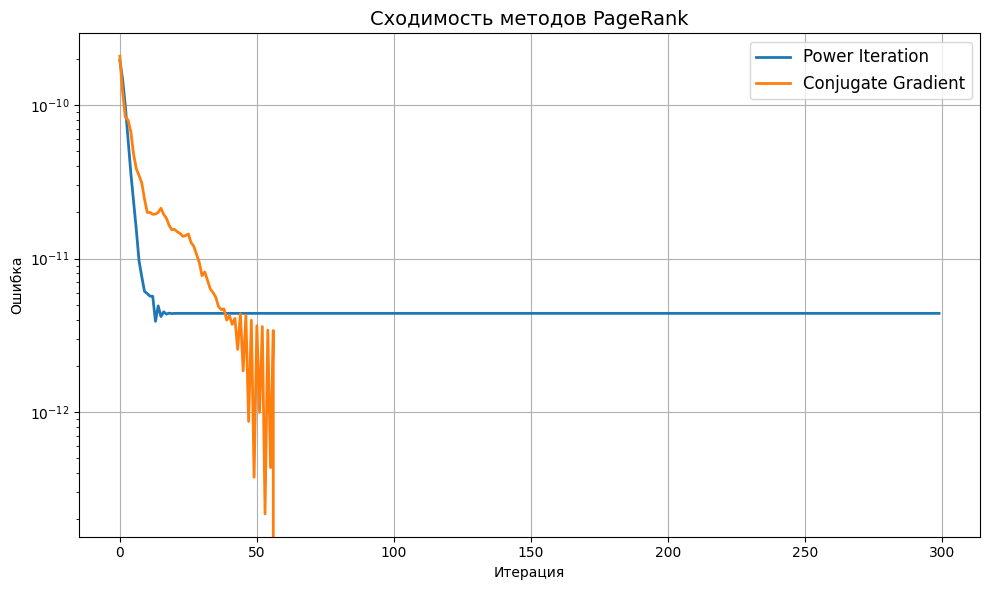

In [55]:
plt.figure(figsize=(10, 6))
plt.semilogy(errors_iter, label='Power Iteration', linewidth=2)
plt.semilogy(errors_cg, label='Conjugate Gradient', linewidth=2)

plt.title('Сходимость методов PageRank', fontsize=14)
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Визуализируйте графы.

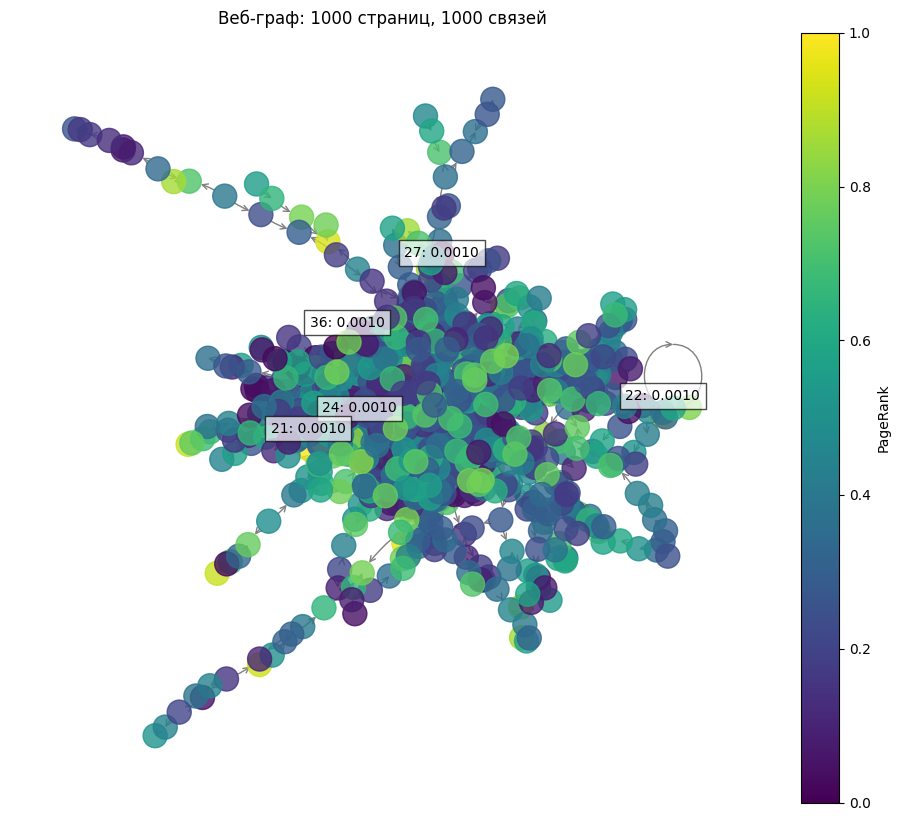

In [34]:
visualize_web_graph(links, n, x_cg)

Выведите финальный вид heat map-а графа переходов.

In [ ]:
# Ваше решение (Code)

__е) (1 балл)__ Постройте графы с различным числом кластеров, используя предоставленную функцию `generate_clustered_web_graph`. Для каждого графа запустите метод простой итерации и метод сопряжённых градиентов.

In [ ]:
def generate_clustered_web_graph(n, n_clusters=1, intra_density=0.3, inter_density=0.01):
    """
    Генерирует граф с кластерами страниц

    Параметры:
        n (int): Количество страниц
        n_clusters (int): Число кластеров
        intra_density (float): Плотность связей внутри кластера
        inter_density (float): Плотность связей между кластерами

    Возвращает:
        links (list): Список связей (from, to)
    """
    # Разделяем страницы на кластеры
    cluster_sizes = [n // n_clusters] * n_clusters
    cluster_sizes[-1] += n % n_clusters  # Добавляем остаток к последнему кластеру
    clusters = []
    start_idx = 0
    for size in cluster_sizes:
        clusters.append(list(range(start_idx, start_idx + size)))
        start_idx += size

    links = []

    # Генерируем связи внутри кластеров
    for cluster in clusters:
        for i in cluster:
            for j in cluster:
                if i != j and np.random.rand() < intra_density:
                    links.append((i, j))

    # Генерируем связи между кластерами
    for i in range(n):
        for j in range(n):
            # Проверяем, что страницы в разных кластерах
            in_same_cluster = any(i in c and j in c for c in clusters)
            if not in_same_cluster and np.random.rand() < inter_density:
                links.append((i, j))

    return links

In [ ]:
def analyze_cluster_impact(cluster_counts, n=1000, max_iter=500, alpha = 0.85, eps=1e-16):
    """
    Анализ влияния числа кластеров на сходимость
    """
    results = {}

    for n_clusters in cluster_counts:
        print(f"\nАнализ для {n_clusters} кластеров...")

        # YOUR CODE HERE

    return results

In [ ]:
cluster_counts = [1, 2, 4, 8]
results = analyze_cluster_impact(cluster_counts)

Постройте графики сходимости.

In [ ]:
# Ваше решение (Code)

Постройте спектры собственных значений матрицы переходов.

In [ ]:
# Ваше решение (Code)

__ж) (1 балл)__ Перейдём к анализу на реальных данных. Вам предлагается рассмотреть три графа из коллекции [SNAP](https://snap.stanford.edu/data/):

* [`email-Eu-core`](https://snap.stanford.edu/data/email-Eu-core.txt.gz)
* [`ca-GrQc`](https://snap.stanford.edu/data/ca-GrQc.txt.gz)
* [`wiki-Vote`](https://snap.stanford.edu/data/wiki-Vote.txt.gz)

Для корректного сравнения выберите из каждого графа подграф примерно одинакового размера (например, по 1000 вершин), выделяя при этом наиболее связную компоненту.

In [ ]:
def download_and_load_graph(dataset_name):
    """
    Загрузка графа из SNAP по имени датасета.
    """
    url_map = {
        "email-eu-core": "https://snap.stanford.edu/data/email-Eu-core.txt.gz",
        "ca-grqc": "https://snap.stanford.edu/data/ca-GrQc.txt.gz",
        "wiki-vote":  "https://snap.stanford.edu/data/wiki-Vote.txt.gz"
    }

    if dataset_name.lower() not in url_map:
        raise ValueError(f"Dataset '{dataset_name}' не поддерживается.")

    url = url_map[dataset_name.lower()]
    filename = dataset_name + ".txt.gz"

    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)

    edges = []
    with gzip.open(filename, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) == 2:
                edges.append((int(parts[0]), int(parts[1])))

    return edges

In [ ]:
def extract_subgraph(edges, max_nodes=1000, is_directed=False):
    """
    Создаёт подграф из первого connected компонента с максимум max_nodes вершин.
    Возвращает edges подграфа и число вершин n.
    """
    G = nx.DiGraph() if is_directed else nx.Graph()
    G.add_edges_from(edges)

    if is_directed:
        components = nx.weakly_connected_components(G)
    else:
        components = nx.connected_components(G)

    largest_cc = max(components, key=len)
    nodes_sub = list(largest_cc)[:max_nodes]
    G_sub = G.subgraph(nodes_sub).copy()

    # Перенумерация узлов в [0, n-1]
    mapping = {old_label: new_label for new_label, old_label in enumerate(G_sub.nodes())}
    G_sub = nx.relabel_nodes(G_sub, mapping)

    edges_sub = list(G_sub.edges())
    n_sub = G_sub.number_of_nodes()
    return edges_sub, n_sub

Проведите анализ аналогично прошлым пунктам. Постройте графики сходимости, визуализацию подграфов и спектры собственных значений матриц.

In [ ]:
# Ваше решение (Code)

In [ ]:
# Ваше решение (Code)

In [ ]:
# Ваше решение (Code)